In [1]:
import sys
import os
sys.path.append(os.path.abspath("DatasetGeneration/DataGenerator"))

from DatasetGeneration.DataGenerator.utils2 import save_kde, load_kde, TruncatedKDE
from DatasetGeneration.DataGenerator.utils import read_dataset
from DatasetGeneration.DataGenerator.scgen import SCGen
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import cv2
import shutil
from scipy.ndimage import gaussian_filter


def event_image(array_from_h5, img_size: tuple[int, int], normalize: bool = False) -> np.ndarray:
        """
        Rasterise the selected event to a 2-D hit-count map.

        Parameters
        img_size   : (H, W) in pixels
        normalize  : if True, scale to [0,1]

        Returns
        np.ndarray[H,W]   float32 image
        """

        h, w = img_size
        (x_min, x_max), (y_min, y_max) = (-600, 600), (-600, 600)
        sx = (w - 1) / (x_max - x_min)
        sy = (h - 1) / (y_max - y_min)

        img = np.zeros((h, w), dtype=np.float32)
        for ring in array_from_h5['rings']:
            if not len(ring):
                continue
            x_pix = np.rint((ring[:, 0] - x_min) * sx).astype(int)
            y_pix = np.rint((y_max - ring[:, 1]) * sy).astype(int)         # y origin at top
            m = (x_pix >= 0) & (x_pix < w) & (y_pix >= 0) & (y_pix < h)
            img[y_pix[m], x_pix[m]] += 1

        if normalize and img.max() > 0:
            img /= img.max()

        return img



def fromSCgen_to_UNet_format(scgen, output_dir: str, image_size=(800, 800), sigma=2, h5_file=False):
    """
    Organizza i dati generati per UNet: immagini e heatmap gaussiane dei keypoint.

    Parameters
    ----------
    scgen : SCGen
        Generatore dati con eventi simulati.
    output_dir : str
        Cartella di output.
    image_size : tuple[int, int]
        Risoluzione finale (H, W) delle immagini.
    sigma : float
        Deviazione standard della gaussiana per ogni keypoint.
    h5_file : bool
        Se True, i dati provengono da file HDF5.
    """
    img_h, img_w = image_size
    images_dir = os.path.join(output_dir, "images", "train")
    labels_dir = os.path.join(output_dir, "labels", "train")
    centers_dir = os.path.join(output_dir, "centers", "train")

    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)
    os.makedirs(centers_dir, exist_ok=True)

    # Coordinate del rivelatore
    if not h5_file:
        x_min, x_max = scgen.detector_size[0]
        y_min, y_max = scgen.detector_size[1]
    else:
        x_min, x_max = (-600, 600)
        y_min, y_max = (-600, 600)

    for idx in range(len(scgen)):
        # 1. Carica immagine
        if not h5_file:
            img = scgen.event_image(idx, (img_h, img_w), normalize=False)
        else:
            img = event_image(scgen[idx], (img_h, img_w), normalize=False)
        
        img_uint8 = (255 * img / img.max()).astype(np.uint8) if img.max() > 0 else img.astype(np.uint8)
        img_name = f"event_{idx}.png"
        cv2.imwrite(os.path.join(images_dir, img_name), img_uint8)

        # 2. Estrai centri
        event = scgen[idx]
        centers = event['centers']

        if len(centers) == 0:
            print(f"[WARNING] Nessun keypoint nell'evento {idx}.")
            continue  # Skippa eventi vuoti

        def to_img_coords(x, y):
            x_img = (x - x_min) / (x_max - x_min)
            y_img = (y_max - y) / (y_max - y_min)  # Flip y
            return x_img, y_img

        centers_img = np.array([to_img_coords(x, y) for x, y in centers])
        centers_img[:, 0] *= img_w
        centers_img[:, 1] *= img_h

        # 3. Crea heatmap
        heatmap = np.zeros((img_h, img_w), dtype=np.float32)
        for x, y in centers_img:
            x, y = int(x), int(y)
            if 0 <= x < img_w and 0 <= y < img_h:
                heatmap[y, x] = 1.0

        heatmap = gaussian_filter(heatmap, sigma=sigma)

        # 4. Salva heatmap come PNG
        heatmap_uint8 = (255 * heatmap / heatmap.max()).astype(np.uint8) if heatmap.max() > 0 else heatmap.astype(np.uint8)
        label_name = os.path.splitext(img_name)[0] + ".png"
        cv2.imwrite(os.path.join(labels_dir, label_name), heatmap_uint8)
        
        # 5. Salva i centri in CSV
        centers_df = pd.DataFrame(centers_img, columns=['x', 'y'])
        centers_csv_path = os.path.join(centers_dir, os.path.splitext(img_name)[0] + "_centers.csv")
        centers_df.to_csv(centers_csv_path, index=False)




def fromSCgen_to_UNet_format_npy(scgen, output_dir: str, image_size=(800, 800), sigma=2, h5_file=False):
    """
    Organizza i dati generati per UNet: immagini e heatmap gaussiane dei keypoint, salvati in formato .npy (float32, normalizzati).

    Parameters
    ----------
    scgen : SCGen
        Generatore dati con eventi simulati.
    output_dir : str
        Cartella di output.
    image_size : tuple[int, int]
        Risoluzione finale (H, W) delle immagini.
    sigma : float
        Deviazione standard della gaussiana per ogni keypoint.
    h5_file : bool
        Se True, i dati provengono da file HDF5.
    """
    img_h, img_w = image_size
    images_dir = os.path.join(output_dir, "images", "train")
    labels_dir = os.path.join(output_dir, "labels", "train")
    centers_dir = os.path.join(output_dir, "centers", "train")

    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)
    os.makedirs(centers_dir, exist_ok=True)

    # Coordinate del rivelatore
    if not h5_file:
        x_min, x_max = scgen.detector_size[0]
        y_min, y_max = scgen.detector_size[1]
    else:
        x_min, x_max = (-600, 600)
        y_min, y_max = (-600, 600)

    for idx in range(len(scgen)):
        # 1. Carica immagine normalizzata [0,1]
        if not h5_file:
            img = scgen.event_image(idx, (img_h, img_w), normalize=True)
        else:
            img = event_image(scgen[idx], (img_h, img_w), normalize=True)

        # 2. Salva immagine .npy
        img_name = f"event_{idx}.npy"
        np.save(os.path.join(images_dir, img_name), img.astype(np.float32))

        # 3. Estrai centri
        event = scgen[idx]
        centers = event['centers']
        if len(centers) == 0:
            print(f"[WARNING] Nessun keypoint nell'evento {idx}.")
            continue

        def to_img_coords(x, y):
            x_img = (x - x_min) / (x_max - x_min)
            y_img = (y_max - y) / (y_max - y_min)  # Flip y
            return x_img, y_img

        centers_img = np.array([to_img_coords(x, y) for x, y in centers])
        centers_img[:, 0] *= img_w
        centers_img[:, 1] *= img_h

        # 4. Crea heatmap float32
        heatmap = np.zeros((img_h, img_w), dtype=np.float32)
        for x, y in centers_img:
            x, y = int(x), int(y)
            if 0 <= x < img_w and 0 <= y < img_h:
                heatmap[y, x] = 1.0
        heatmap = gaussian_filter(heatmap, sigma=sigma)

        # 5. Salva heatmap .npy normalizzata
        if heatmap.max() > 0:
            heatmap /= heatmap.max()
        label_name = f"event_{idx}.npy"
        np.save(os.path.join(labels_dir, label_name), heatmap.astype(np.float32))

        # 6. Salva i centri in CSV
        centers_df = pd.DataFrame(centers_img, columns=['x', 'y'])
        centers_csv_path = os.path.join(centers_dir, f"event_{idx}_centers.csv")
        centers_df.to_csv(centers_csv_path, index=False)
        




def visualize_heatmap_unet(image_path: str, heatmap_path: str, alpha: float = 0.5, cmap='jet', show_side_by_side=False):
    """
    Visualizza un'immagine e la sua heatmap associata (come in UNet).

    Parameters
    ----------
    image_path : str
        Percorso dell'immagine originale (png).
    heatmap_path : str
        Percorso della heatmap (png).
    alpha : float
        Fattore di fusione per sovrapporre la heatmap (0=solo immagine, 1=solo heatmap).
    cmap : str
        Colormap matplotlib per la heatmap (es: 'jet', 'hot', 'viridis').
    show_side_by_side : bool
        Se True, mostra immagine e heatmap affiancate. Se False, sovrapposte.
    """
    # 1. Carica immagine
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Immagine non trovata: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]

    # 2. Carica heatmap
    heatmap = cv2.imread(heatmap_path, cv2.IMREAD_GRAYSCALE)
    if heatmap is None:
        raise FileNotFoundError(f"Heatmap non trovata: {heatmap_path}")
    heatmap = cv2.resize(heatmap, (w, h))  # match dimensions

    # 3. Applica colormap
    heatmap_color = cv2.applyColorMap(heatmap, getattr(cv2, f'COLORMAP_{cmap.upper()}'))

    # 4. Visualizzazione
    if show_side_by_side:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(image)
        axs[0].set_title("Immagine originale")
        axs[1].imshow(heatmap, cmap=cmap)
        axs[1].set_title("Heatmap")
        for ax in axs:
            ax.axis("off")
        plt.tight_layout()
        plt.show()
    else:
        overlay = cv2.addWeighted(image, 1 - alpha, heatmap_color, alpha, 0)
        plt.figure(figsize=(6, 6))
        plt.imshow(overlay)
        plt.title(f"Overlay heatmap\n{os.path.basename(image_path)}")
        plt.axis("off")
        plt.tight_layout()
        plt.show()



def visualize_heatmap_unet_npy(image_path: str, heatmap_path: str, alpha: float = 0.5, cmap='jet', show_side_by_side=False):
    """
    Visualizza un'immagine e la sua heatmap associata (come in UNet).

    Parameters
    ----------
    image_path : str
        Percorso dell'immagine originale (formato .npy, float32 normalizzata).
    heatmap_path : str
        Percorso della heatmap (formato .npy, float32 normalizzata).
    alpha : float
        Fattore di fusione per sovrapporre la heatmap (0=solo immagine, 1=solo heatmap).
    cmap : str
        Colormap matplotlib (es: 'jet', 'hot', 'viridis').
    show_side_by_side : bool
        Se True, mostra immagine e heatmap affiancate. Se False, sovrapposte.
    """
    # 1. Carica immagine e heatmap (float32 normalizzati)
    image = np.load(image_path)   # [H,W]
    heatmap = np.load(heatmap_path)  # [H,W]

    if image.ndim == 2:
        image = np.stack([image] * 3, axis=-1)  # grayscale → RGB fake

    # 2. Converte in uint8 per visualizzazione
    image_uint8 = (255 * np.clip(image, 0, 1)).astype(np.uint8)
    heatmap_uint8 = (255 * np.clip(heatmap, 0, 1)).astype(np.uint8)

    # 3. Applica colormap
    try:
        cmap_enum = getattr(cv2, f'COLORMAP_{cmap.upper()}')
    except AttributeError:
        raise ValueError(f"Colormap '{cmap}' non valida per OpenCV.")
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cmap_enum)

    # 4. Visualizzazione
    if show_side_by_side:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(image_uint8)
        axs[0].set_title("Immagine originale")
        axs[1].imshow(heatmap_uint8, cmap=cmap)
        axs[1].set_title("Heatmap")
        for ax in axs:
            ax.axis("off")
        plt.tight_layout()
        plt.show()
    else:
        overlay = cv2.addWeighted(image_uint8, 1 - alpha, heatmap_color, alpha, 0)
        plt.figure(figsize=(6, 6))
        plt.imshow(overlay)
        plt.title(f"Overlay heatmap\n{os.path.basename(image_path)}")
        plt.axis("off")
        plt.tight_layout()
        plt.show()



def split_train_val(dataset_dir, split_ratio=0.8):
    """
    Divide immagini e label in train e val in base a split_ratio.
    Assume che tutte le immagini e le etichette siano in formato .png.

    Parameters
    ----------
    dataset_dir : str
        Cartella base del dataset (che contiene 'images/train' e 'labels/train').
    split_ratio : float
        Percentuale di dati da tenere per il train (default 0.8).
    """

    # Percorsi
    images_train_dir = os.path.join(dataset_dir, "images", "train")
    labels_train_dir = os.path.join(dataset_dir, "labels", "train")
    centers_train_dir = os.path.join(dataset_dir, "centers", "train")
    images_val_dir   = os.path.join(dataset_dir, "images", "val")
    labels_val_dir   = os.path.join(dataset_dir, "labels", "val")
    centers_val_dir  = os.path.join(dataset_dir, "centers", "val")

    os.makedirs(images_val_dir, exist_ok=True)
    os.makedirs(labels_val_dir, exist_ok=True)
    os.makedirs(centers_val_dir, exist_ok=True)

    # Lista immagini PNG ordinate
    all_images = sorted([f for f in os.listdir(images_train_dir) if f.endswith(".png")])
    split_index = int(len(all_images) * split_ratio)
    val_images = all_images[split_index:]

    # Spostamento diretto
    for img_name in val_images:
        base = os.path.splitext(img_name)[0] + ".png"

        shutil.move(os.path.join(images_train_dir, base), os.path.join(images_val_dir, base))
        shutil.move(os.path.join(labels_train_dir, base), os.path.join(labels_val_dir, base))
        shutil.move(os.path.join(centers_train_dir, base.replace(".png", "_centers.csv")), os.path.join(centers_val_dir, base.replace(".png", "_centers.csv")))

    print(f"Spostate {len(val_images)} immagini (e relative label) nella validation set.")
    
    

def split_train_val_npy(dataset_dir, split_ratio=0.8):
    """
    Divide immagini, label e centri in train e val in base a split_ratio.
    Assume che immagini e label siano in formato .npy, i centri in .csv.

    Parameters
    ----------
    dataset_dir : str
        Cartella base del dataset (che contiene 'images/train', 'labels/train', 'centers/train').
    split_ratio : float
        Percentuale di dati da tenere per il train (default 0.8).
    """

    # Percorsi
    images_train_dir = os.path.join(dataset_dir, "images", "train")
    labels_train_dir = os.path.join(dataset_dir, "labels", "train")
    centers_train_dir = os.path.join(dataset_dir, "centers", "train")

    images_val_dir   = os.path.join(dataset_dir, "images", "val")
    labels_val_dir   = os.path.join(dataset_dir, "labels", "val")
    centers_val_dir  = os.path.join(dataset_dir, "centers", "val")

    os.makedirs(images_val_dir, exist_ok=True)
    os.makedirs(labels_val_dir, exist_ok=True)
    os.makedirs(centers_val_dir, exist_ok=True)

    # Lista immagini .npy ordinate
    all_images = sorted([f for f in os.listdir(images_train_dir) if f.endswith(".npy")])
    split_index = int(len(all_images) * split_ratio)
    val_images = all_images[split_index:]

    # Sposta immagini, label e centri
    for img_name in val_images:
        base_name = os.path.splitext(img_name)[0]

        # Sposta immagine
        shutil.move(
            os.path.join(images_train_dir, img_name),
            os.path.join(images_val_dir, img_name)
        )

        # Sposta label (heatmap)
        shutil.move(
            os.path.join(labels_train_dir, img_name),
            os.path.join(labels_val_dir, img_name)
        )

        # Sposta centri CSV
        csv_name = base_name + "_centers.csv"
        shutil.move(
            os.path.join(centers_train_dir, csv_name),
            os.path.join(centers_val_dir, csv_name)
        )

    print(f"Spostate {len(val_images)} immagini (.npy) e relative label/centri nella validation set.")

/user/gr1/delphi/dghezzi/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import of momentum and centers distributions
ptypes = [211, 321, 2212, 11, 13]
log_momenta_dist = {}
for ptype in ptypes:
    log_momenta_dist[ptype] = load_kde(f'DatasetGeneration/distributions/log_momenta_kdes/{ptype}-kde.npz')
centers_dist = load_kde('DatasetGeneration/distributions/centers_R1-kde.npz')
radial_noise = (0, 1.5)  # Mean and standard deviation for radial noise

In [11]:
# Create the SCGen instance
scgen = SCGen(
    particle_types=ptypes,
    refractive_index=1.0014,
    detector_size=((-600, 600), (-600, 600)),
    momenta_log_distributions=log_momenta_dist,
    centers_distribution=centers_dist,
    radial_noise=radial_noise,
    N_init=20,
    max_radius=100.0
)


directory = r'/user/gr1/delphi/dghezzi/SharedDataset_22500_2500_150_175_npy'

if os.path.exists(directory):
    os.makedirs(directory, exist_ok=True)

# Generate the data
N = 25000
N_rings = (150, 175)
dataset = scgen.generate_dataset(
    num_events=N, # Giovanni ha messo 200 eventi
    num_particles_per_event=N_rings, # Giovanni ha messo (160,180) tuple 
    parallel=True, # NOTA: lasciare TRUE per generare gli eventi in parallelo, altrimenti NON FUNZIONA!
    batch_size=128,
    progress_bar=True
)

print(f"Generated {len(dataset)} events with {sum(len(event['rings']) for event in dataset)} total rings.")
    
scgen.save_dataset(f'{directory}.h5')

100%|██████████| 25000/25000 [1:11:30<00:00,  5.83it/s]


Generated 25000 events with 4061359 total rings.


In [3]:
h5_path = '/user/gr1/delphi/dghezzi/SharedDataset_22500_2500_150_175_npy/SharedDataset_22500_2500_150_175_npy.h5'
scgen = read_dataset(h5_path)
directory = '/user/gr1/delphi/dghezzi/SharedDataset_22500_2500_150_175_npy/UNet/416px'
fromSCgen_to_UNet_format_npy(scgen, directory, image_size=(416,416), sigma=2, h5_file=True)

split_train_val_npy(directory, split_ratio=0.9)

Spostate 2500 immagini (.npy) e relative label/centri nella validation set.


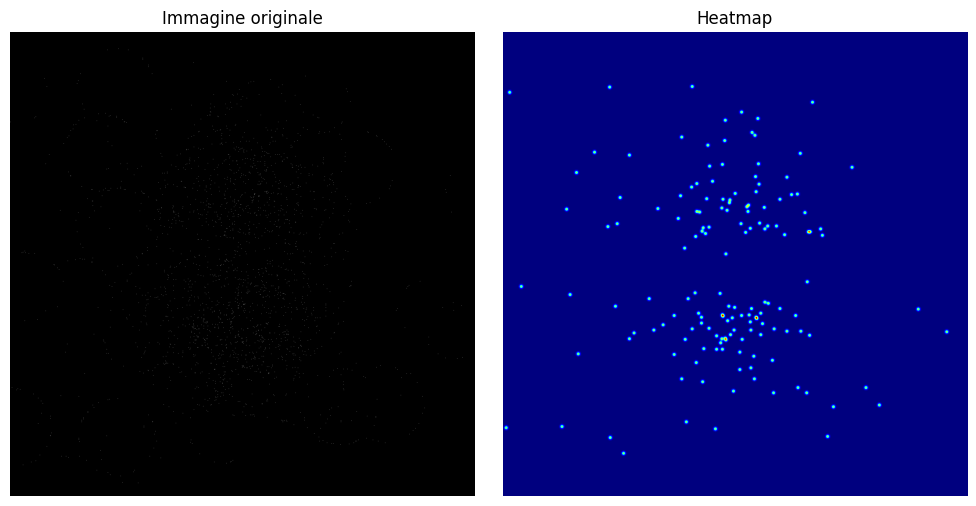

In [14]:
visualize_heatmap_unet_npy(
    image_path=os.path.join(directory, "images", "train", "event_70.npy"),
    heatmap_path=os.path.join(directory, "labels", "train", "event_70.npy"),
    alpha=0.5,
    cmap='jet',
    show_side_by_side=True
)

In [17]:
directory = '/user/gr1/delphi/dghezzi/SharedDataset_22500_2500_150_175_npy/UNet/420px'
fromSCgen_to_UNet_format_npy(scgen, directory, image_size=(420, 420), sigma=2, h5_file=False)

split_train_val_npy(directory, split_ratio=0.9)

Spostate 2500 immagini (.npy) e relative label/centri nella validation set.


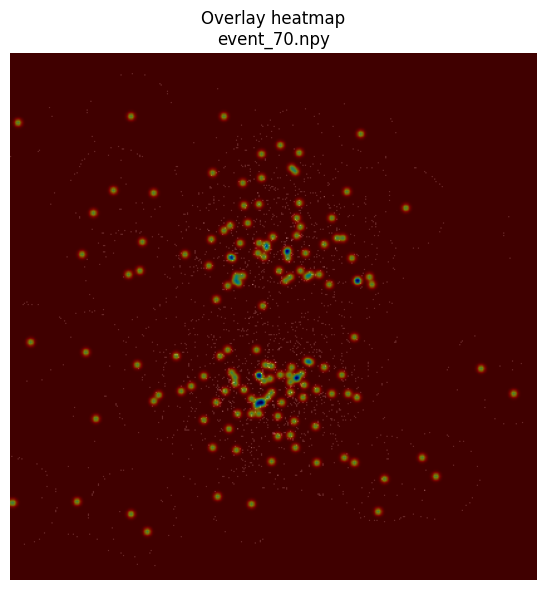

In [18]:
visualize_heatmap_unet_npy(
    image_path=os.path.join(directory, "images", "train", "event_70.npy"),
    heatmap_path=os.path.join(directory, "labels", "train", "event_70.npy"),
    alpha=0.5,
    cmap='jet',
    show_side_by_side=False
)

In [12]:
# vario numero di anelli: per ognuna di queste categorie, genero 1000 immagini

directory = r'/user/gr1/delphi/dghezzi/UNet/UNet_dataset/study_rings_npy'

if os.path.exists(directory):
    os.makedirs(directory, exist_ok=True)

N_rings = np.arange(10, 200, 10)
print(N_rings)

scgen = SCGen(
    particle_types=ptypes,
    refractive_index=1.0014,
    detector_size=((-600, 600), (-600, 600)),
    momenta_log_distributions=log_momenta_dist,
    centers_distribution=centers_dist,
    radial_noise=radial_noise,
    N_init=20,
    max_radius=100.0
)

for N in N_rings:
    
    dataset = scgen.generate_dataset(
        num_events=1000, 
        num_particles_per_event=N, 
        parallel=True,
        batch_size=128,
        progress_bar=True
    )
    
    dir = directory + f'/{N}_rings'
    
    if os.path.exists(dir):
        os.makedirs(dir, exist_ok=True)
        
    fromSCgen_to_UNet_format_npy(scgen, dir, image_size=(800, 800), sigma=2, h5_file=False)


[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190]


100%|██████████| 1000/1000 [03:08<00:00,  5.30it/s]


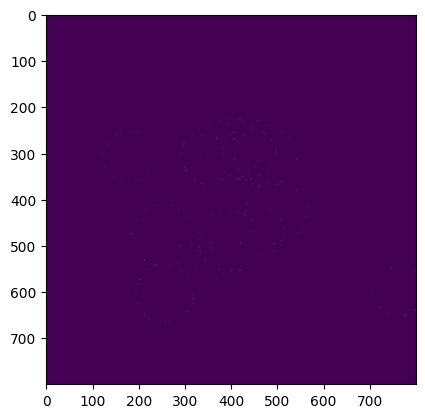

In [11]:
img = np.load('/user/gr1/delphi/dghezzi/UNet/UNet_dataset/study_rings_npy/20_rings/images/train/event_1.npy')
plt.imshow(img)

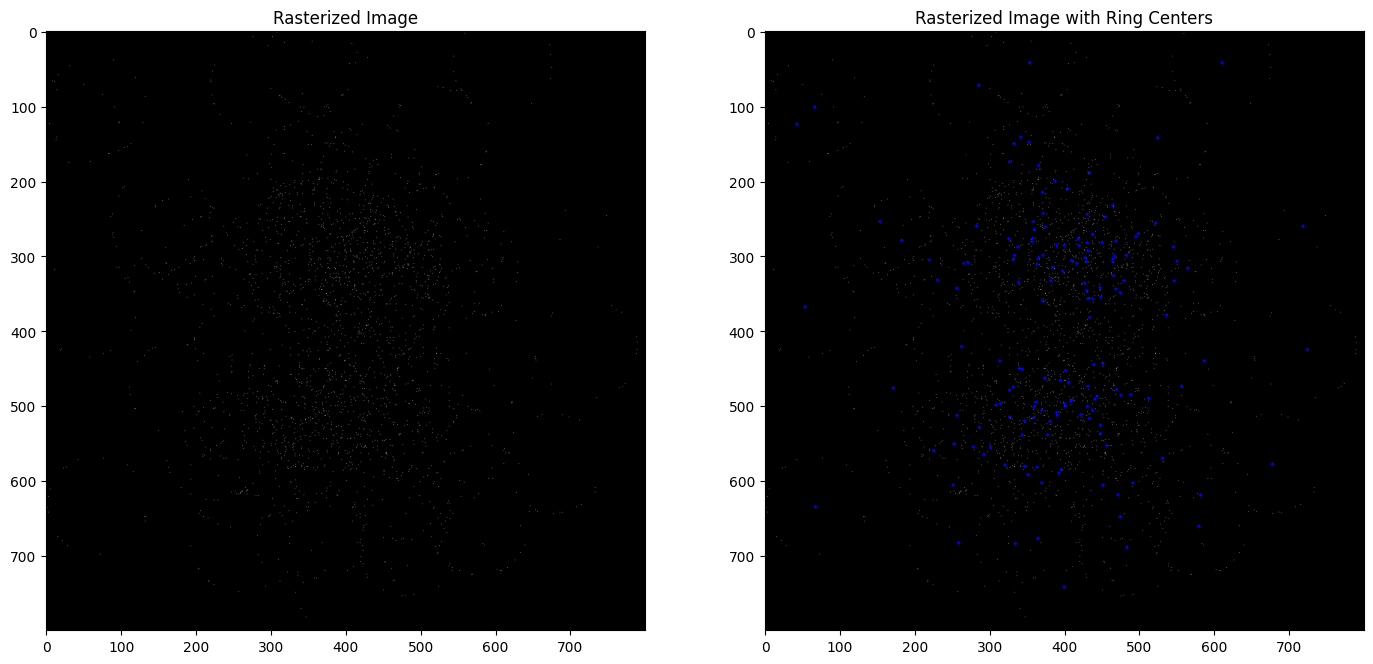

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from UNet import load_keypoints_from_csv

# Carico immagine
image = np.load('/user/gr1/delphi/dghezzi/UNet/UNet_dataset/study_rings_npy/160_rings/images/train/event_0.npy')

# Subplots
fig, axes = plt.subplots(1, 2, figsize=(17, 8))

# Immagine originale
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Rasterized Image')
axes[0].axis()

# Immagine con centri
# Copio l'immagine e la converto in 3 canali
image_with_centers = cv2.cvtColor((image*255).astype(np.uint8), cv2.COLOR_GRAY2BGR)

# Carico keypoints
keypoints_gt = load_keypoints_from_csv('/user/gr1/delphi/dghezzi/UNet/UNet_dataset/study_rings_npy/160_rings/centers/train/event_0_centers.csv')

# Disegno cerchi
for (x, y) in keypoints_gt:
    cv2.circle(image_with_centers, (int(x), int(y)), 2, (255, 0, 0), -1) 

# Mostro immagine con centri
axes[1].imshow(cv2.cvtColor(image_with_centers, cv2.COLOR_BGR2RGB))
axes[1].set_title('Rasterized Image with Ring Centers')
axes[1].axis()

plt.savefig('/user/gr1/delphi/dghezzi/UNet/example.png', bbox_inches='tight', dpi=150)
plt.show()

In [15]:
heatmap = np.load(os.path.join(directory, "labels", "train", "event_1.npy"))
num_positive_pixels = np.sum(heatmap > 0)
ratio = num_positive_pixels / (heatmap.size)
print(f"Numero di pixel positivi in una heatmap: {num_positive_pixels}")
print(f"Numero totale di pixel in una heatmap: {heatmap.size}")
print(f"Rapporto tra pixel positivi e totali in una heatmap: {ratio*100:.3f}%")
print('')

val_labels_dir = os.path.join(directory, "labels", "val")
pos_weights = []

for label_file in os.listdir(val_labels_dir):
    if label_file.endswith('.npy'):
        heatmap = np.load(os.path.join(val_labels_dir, label_file))
        
        pos_mass = np.sum(heatmap)  # somma intensità positive (heatmap continua)
        neg_mass = heatmap.size - pos_mass
        
        pos_weight_img = neg_mass / (pos_mass + 1e-6)
        pos_weights.append(pos_weight_img)

pos_weights = np.array(pos_weights)
mean_pos_weight = np.mean(pos_weights)
std_pos_weight = np.std(pos_weights) / np.sqrt(len(pos_weights))

print(f"Pos weight medio per il validation set: {mean_pos_weight:.4f} ± {std_pos_weight:.4f} (n={len(pos_weights)})")

Numero di pixel positivi in una heatmap: 38737
Numero totale di pixel in una heatmap: 640000
Rapporto tra pixel positivi e totali in una heatmap: 6.053%

Pos weight medio per il validation set: 274.6051 ± 1.0284 (n=1000)


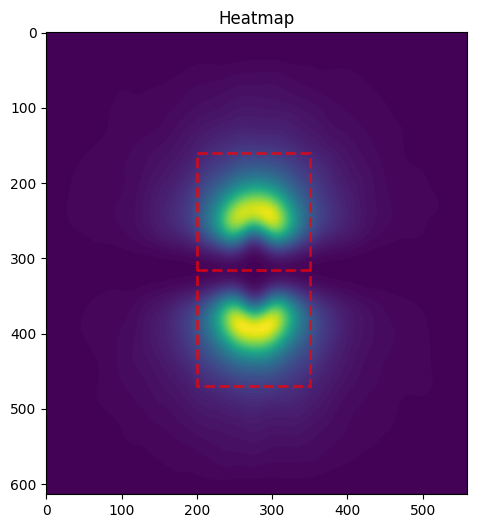

'\n# fai lo stesso per l\'immagine e mettici sopra i punti dei keypoint ground truth\nimage_path=os.path.join(directory, "images", "train", "event_1.npy")\nimage = np.load(image_path)\nplt.figure(figsize=(6, 6))\nplt.imshow(image, cmap=\'gray\', interpolation=\'nearest\')\nplt.title(\'Image\')\nplt.xlabel(\'X-axis\')\nplt.ylabel(\'Y-axis\')\nplt.grid(True, which=\'both\', color=\'white\', linestyle=\'-\', linewidth=0.5)\nplt.xticks(np.arange(0, image.shape[1], step=50), rotation=45)\nplt.yticks(np.arange(0, image.shape[0], step=50))\nplt.tight_layout()\n\nplt.axvline(x=200, color=\'red\', linestyle=\'--\', alpha=0.7)\nplt.axvline(x=350, color=\'red\', linestyle=\'--\', alpha=0.7)\nplt.axhline(y=200, color=\'red\', linestyle=\'--\', alpha=0.7)\nplt.axhline(y=440, color=\'red\', linestyle=\'--\', alpha=0.7)\n\n# Aggiungi i punti dei keypoint ground truth\nkeypoints_path = os.path.join(directory, "centers", \'train\', "event_1_centers.csv")\n\nfrom UNet import load_keypoints_from_csv\nkey

In [37]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

kde = mpimg.imread(r'/user/gr1/delphi/dghezzi/UNet/kde.PNG')

plt.figure(figsize=(6, 6))
plt.imshow(kde)
plt.title('Heatmap')

# Rettangolo
x_start, x_end = 200, 350
y_start, y_end = 160, 470
rect_width = x_end - x_start
rect_height = y_end - y_start
rect = plt.Rectangle((x_start, y_start), rect_width, rect_height,
                     linewidth=2, edgecolor='red', facecolor='none', linestyle='--', alpha=0.7)
plt.gca().add_patch(rect)

# Segmento orizzontale a metà del rettangolo
y_mid = (y_start + y_end) / 2
plt.plot([x_start, x_end], [y_mid, y_mid], color='red', linestyle='--', linewidth=2, alpha=0.7)

plt.show()


'''
# fai lo stesso per l'immagine e mettici sopra i punti dei keypoint ground truth
image_path=os.path.join(directory, "images", "train", "event_1.npy")
image = np.load(image_path)
plt.figure(figsize=(6, 6))
plt.imshow(image, cmap='gray', interpolation='nearest')
plt.title('Image')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True, which='both', color='white', linestyle='-', linewidth=0.5)
plt.xticks(np.arange(0, image.shape[1], step=50), rotation=45)
plt.yticks(np.arange(0, image.shape[0], step=50))
plt.tight_layout()

plt.axvline(x=200, color='red', linestyle='--', alpha=0.7)
plt.axvline(x=350, color='red', linestyle='--', alpha=0.7)
plt.axhline(y=200, color='red', linestyle='--', alpha=0.7)
plt.axhline(y=440, color='red', linestyle='--', alpha=0.7)

# Aggiungi i punti dei keypoint ground truth
keypoints_path = os.path.join(directory, "centers", 'train', "event_1_centers.csv")

from UNet import load_keypoints_from_csv
keypoints = load_keypoints_from_csv(keypoints_path)
for i in range(len(keypoints)):
    plt.plot(keypoints[i][0], keypoints[i][1], 'yellow', marker='.', markersize=2)

plt.show()
'''

In [40]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Percorsi delle immagini
img1_path = 'result_2patches.png'
img2_path = 'result_3patches.png'

# Carica immagini
img1 = mpimg.imread(img1_path)
img2 = mpimg.imread(img2_path)

# Ridimensiona entrambe le immagini alla dimensione più piccola
h = min(img1.shape[0], img2.shape[0])
w = min(img1.shape[1], img2.shape[1])
img1_resized = img1[:h, :w]
img2_resized = img2[:h, :w]

# Crea spazio bianco tra le immagini
gap = 20  # larghezza in pixel
if img1.ndim == 3:
    # immagini RGB o RGBA
    white_space = np.ones((h, gap, img1.shape[2]), dtype=img1.dtype)
else:
    # immagini grayscale
    white_space = np.ones((h, gap), dtype=img1.dtype)

# Affianca immagini con spazio bianco
combined = np.concatenate([img1_resized, white_space, img2_resized], axis=1)

# Visualizza e salva senza assi
plt.figure(figsize=(combined.shape[1]/100, combined.shape[0]/100), dpi=100)
plt.imshow(combined)
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig('combined.png', bbox_inches='tight', pad_inches=0)
plt.close()

In [6]:
import torch.cuda
torch.cuda.empty_cache()

In [6]:
import os
import numpy as np
from shutil import copy2
from tqdm import tqdm

def crop_center(img, cropx, cropy):
    h, w = img.shape[-2], img.shape[-1]
    startx = w//2 - (cropx//2)
    starty = h//2 - (cropy//2)
    return img[starty:starty+cropy, startx:startx+cropx]

def prepare_double_input_dataset(orig_image_dir, orig_label_dir, out_dir, crop_size=416):
    sets = ['train', 'val']
    os.makedirs(out_dir, exist_ok=True)

    for s in sets:
        orig_images_path = os.path.join(orig_image_dir, s)
        orig_labels_path = os.path.join(orig_label_dir, s)

        out_images1_path = os.path.join(out_dir, 'images1', s)
        out_images2_path = os.path.join(out_dir, 'images2', s)
        out_labels_path = os.path.join(out_dir, 'labels', s)

        os.makedirs(out_images1_path, exist_ok=True)
        os.makedirs(out_images2_path, exist_ok=True)
        os.makedirs(out_labels_path, exist_ok=True)

        file_list = sorted([f for f in os.listdir(orig_images_path) if f.endswith('.npy')])

        for fname in tqdm(file_list, desc=f'Processing {s}'):
            # Carica immagine e label
            img_path = os.path.join(orig_images_path, fname)
            lbl_path = os.path.join(orig_labels_path, fname)

            img = np.load(img_path)
            label = np.load(lbl_path)

            # Salva immagine originale in images1
            out_img1 = os.path.join(out_images1_path, fname)
            np.save(out_img1, img)

            # Ritaglia centro immagine e salva in images2
            img_cropped = crop_center(img, crop_size, crop_size)
            out_img2 = os.path.join(out_images2_path, fname)
            np.save(out_img2, img_cropped)

            # Salva label così com'è (se vuoi ritagliarla, modifica qui)
            out_lbl = os.path.join(out_labels_path, fname)
            np.save(out_lbl, label)
    
    
    
origin_image = r'/user/gr1/delphi/dghezzi/UNet/UNet_dataset/900_100_160_180_npy/images'
origin_label = r'/user/gr1/delphi/dghezzi/UNet/UNet_dataset/900_100_160_180_npy/labels'
output = r'/user/gr1/delphi/dghezzi/UNet/UNet_dataset/900_100_160_180_npy_double_input'

prepare_double_input_dataset(
    orig_image_dir=origin_image,
    orig_label_dir=origin_label,
    out_dir=output,
    crop_size=416
)

print(f"Dataset preparato in {output} con immagini doppie e ritagliate.")

Processing val: 100%|██████████| 100/100 [00:00<00:00, 121.36it/s]

Dataset preparato in /user/gr1/delphi/dghezzi/UNet/UNet_dataset/900_100_160_180_npy_double_input con immagini doppie e ritagliate.


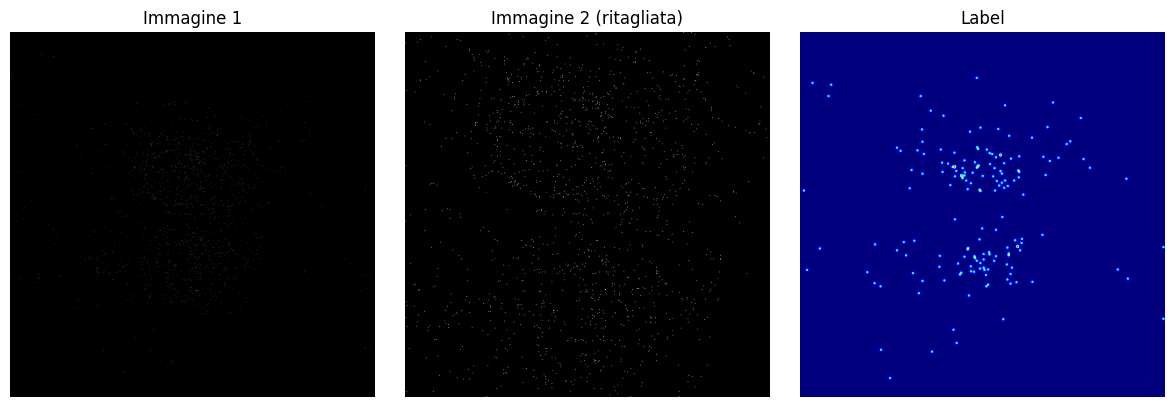

In [7]:
import matplotlib.pyplot as plt

img1 = np.load(os.path.join(output, 'images1', 'train', 'event_1.npy'))
img2 = np.load(os.path.join(output, 'images2', 'train', 'event_1.npy'))
label = np.load(os.path.join(output, 'labels', 'train', 'event_1.npy'))

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img1, cmap='gray')
plt.title('Immagine 1')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img2, cmap='gray')
plt.title('Immagine 2 (ritagliata)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(label, cmap='jet')
plt.title('Label')
plt.axis('off')

plt.tight_layout()
plt.show()